In [60]:
# Al instalar las librerias es necesario tener presente instalar primero tensorflow
# que transformers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
from langcodes import Language
from langdetect import detect
import random
import warnings
from transformers import pipeline
import tensorflow as tf
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
# pd.reset_option(“max_columns”)

# Análisis sentimental y textual de los comentarios de un vídeo de Youtube
Los autores de este trabajo son:

- Nicolás Leonardo Maldonado Garzón
- Elina Filatova 

### Objetivo:
El objetivo de este trabajo es realizar analisys sobre un conjunto de datos. 

### Problema planteado:
#### Analizar comentarios de un video aleatorio en youtube

1. Detectar comentarios positivos y negativos
2. Detectar el contenido del video a traves de palabras más frecuentes
3. Sugerir el motivo por el cual el comentario puede ser positivo o negativo
4. Conclusiones

### Contenido:
1. Inicio 

1.1. Datos recogidos

2. Tratamiento dado a los datos, incluyendo referencia a los formatos usados y las herramientas utilizadas

2.1. Preprocesamiento de datos
- Eliminar datos nulos si existen,
- Limpiar el comentario de emojis,
- Detectar nombres propios (como nombres) y algunos sustantivos,
- Manejar comentarios que consisten en números o enlaces HTTP,
- Detectar el idioma del commentario y tomar la mas frequente para proporcionar coherencia.
- Aplicar las funciones definidas y almacenar los resultados en un DataFrame con referencias a los comentarios originales y nuevos comentarios.

3. Diseño del modelo de datos y/o características que se quieren estudiar 

3.1. Detectar comentarios positivos y negativos

- Cargar y aplicar el modelo de análisis de los sentimientos
- Visualizar resultados y algunos comentarios positivos y algunos negativos al azar

3.2. Detectar el contenido del video a traves de palabras más frecuentes
- Exclusión de palabras comunes
- Cálculo de frecuencia de palabras
- Visualizar resultados

3.3. Sugerir el motivo por el cual el comentario puede ser positivo o negativo
- Estimar qué palabras aparecen predominantemente en comentarios positivos y negativos
- Mostrar los comentarios que han obtenido más respuestas

4. Repetir el algoritmo en otro video con todos los pasos anteriores

5. Conclusiones y aplicaciones potenciales




### 1. Inicio
### 1.1. Datos recogidos

Tomamos el conjunto de datos en Kaggle "Trending YouTube Video Statistics and Comments"

fuente: https://www.kaggle.com/datasets/datasnaek/youtube

In [61]:
# Cargar el conjunto de datos
df = pd.read_csv("archive/GBcomments.csv", sep=',',on_bad_lines='skip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718452 entries, 0 to 718451
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   video_id      718452 non-null  object
 1   comment_text  718424 non-null  object
 2   likes         718452 non-null  int64 
 3   replies       718452 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 21.9+ MB


In [62]:
# Tomar un video aleatorio
np.random.seed(6)
random_ind = np.random.randint(len(df['video_id']))
random_video_id = df.iloc[random_ind].iloc[0]
random_video_id

'L6QAx5mqFKU'

In [63]:
# crear un data frame con un video aleatorio
df_video_selected = df[df['video_id']==random_video_id]
df_video_selected.count()

video_id        600
comment_text    600
likes           600
replies         600
dtype: int64

### 2. Tratamiento dado a los datos, incluyendo referencia a los formatos usados y las herramientas utilizadas
### 2.1. Preprocesamiento de datos

Eliminar datos nulos si existen

In [64]:
# Comprobar si tenemos datos nulos y si es así los descartamos
nulls = df_video_selected.isnull().sum()
if len(nulls[nulls>0]) > 0:
    indices_null = df_video_selected['comment_text'].isnull().index
    df_video_selected.drop(df_video_selected['comment_text'][df_video_selected['comment_text'].isnull()].index, inplace=True)

Definiendo funciones para preprocesar los datos con los siguientes objetivos:
- Limpiar el comentario de emojis,
- Detectar nombres propios (como nombres) y algunos sustantivos,
- Manejar comentarios que consisten en números o enlaces HTTP,
- Detectar el idioma del commentario.


In [11]:
# Limpiar el comentario de emojis,
emoji_pattern = re.compile("["
   u"\U0001F600-\U0001F64F"  # emoticons
   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
   u"\U0001F680-\U0001F6FF"  # transport & map symbols
   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
   u"\U00002500-\U00002BEF"  # chinese char
   u"\U00002702-\U000027B0"
   u"\U00002702-\U000027B0"
   u"\U000024C2-\U0001F251"
   u"\U0001f926-\U0001f937"
   u"\U00010000-\U0010ffff"
   u"\u2640-\u2642"
   u"\u2600-\u2B55"
   u"\u200d"
   u"\u23cf"
   u"\u23e9"
   u"\u231a"
   u"\ufe0f"  # dingbats
   u"\u3030"
   "]+"
)

def find_emojis(x):
    out = re.search(emoji_pattern, x)
    if out:
        return out.group()
    return out

# Detectar nombres propios (como nombres) y algunos sustantivos
def search_nouns(x):
    reg = r"[A-Z][A-z]+"
    # +|\.+))+(\s[A-Z][a-z]+)+)|([A-Z]{2,})|([a-z][A-Z])[a-z]*[A-Z][a-z]
    out = re.search(reg, x)
    if out:
        return out.group()
    return out

# Manejar comentarios que consisten en números o enlaces HTTP
def no_letters(fr):
    reg = r"([A-z])+"
    http = r"https:\/\/[A-z0-9\.\/]+"
    # +|\.+))+(\s[A-Z][a-z]+)+)|([A-Z]{2,})|([a-z][A-Z])[a-z]*[A-Z][a-z]
    out = re.search(reg, fr)
    if out:
        out = re.search(http, fr)
        if out:
            if out.group() == fr: # Excluimos aquellos comentarios que son unicamente una direccion https:...
                return "no comment"
        return fr
    return "no comment"

# Detectar el idioma del commentario
def detect_and_convert_language(text):
    # Detectar el idioma usando langdetect
    lang_code = detect(text)
    # Convertir código de idioma al nombre del idioma usando langcodes
    language_name = Language.make(lang_code).language_name().title()
    return language_name

Aplicar las funciones definidas y almacenar los resultados en un DataFrame con referencias a los comentarios originales y nuevos comentarios.

In [65]:
df_video = df_video_selected
df_video.rename(columns={"comment_text":"original_text"}, inplace=True)
df_video['text_without_emojis'] = df_video['original_text'].apply(lambda x: emoji_pattern.sub(r'', x))
df_video['emojis'] = df_video['original_text'].apply(lambda x: find_emojis(x))
df_video['possible_nouns'] = df_video['text_without_emojis'].apply(lambda x: [search_nouns(i) for i in x.split(" ")])
df_video['possible_nouns'] = df_video['possible_nouns'].apply(lambda x: list(filter(lambda item: item is not None, x)))
df_video['text_without_emojis'] = df_video['text_without_emojis'].apply(lambda x: no_letters(x)) # Aseguramos que todas las cadenas tengan comentarios
df_video['language'] = df_video['text_without_emojis'].apply(lambda x: detect_and_convert_language(x))

Mostramos el resultado de la tabla

In [66]:
df_video.head(5)

,video_id,original_text,likes,replies,text_without_emojis,emojis,possible_nouns,language
145702,L6QAx5mqFKU,"I really don't get this whole gluten thing, I live in Germany and we eat a shit ton of bread, and I never ever have seen a person saying they are bloated because of bread or that they get a tummy ace. I guess a lot of that discomfort comes from processed foods with a lot of shit in it. I always feel like shit after eating a meal at McDonalds or just too much, but never because I ate a piece of bread. I know there are people who are sensitive to gluten or even alergic, but its not that many people. I personally only know one person that is allergic to it and feels and looks a lot better after going vegan. I think the amount and the quality of what you are eating are important and its really naive to think that if you just cut out this or that you will feel better. I guess everyone has to find his own balance of what and how much to eat to feel good by using our brain and informing ourselves at the same time and not just blindly follow what the newest nutritionist tells us. There are many reasons why you can feel bloated or tired like not enough activity, eating too fast, eating processed foods or even eating stuff that the bacteria in your gut like, like onions, if I eat to much onions I get bloated as fuck and then I just fart all the time, just linking it too gluten is not really thought out. Also have you never thought about the chemicals they put on wheat sometimes just before harvest? I guess there are many factors that influence our well being and there is not a perfect solution that fits everybody.",3,0,"I really don't get this whole gluten thing, I live in Germany and we eat a shit ton of bread, and I never ever have seen a person saying they are bloated because of bread or that they get a tummy ace. I guess a lot of that discomfort comes from processed foods with a lot of shit in it. I always feel like shit after eating a meal at McDonalds or just too much, but never because I ate a piece of bread. I know there are people who are sensitive to gluten or even alergic, but its not that many people. I personally only know one person that is allergic to it and feels and looks a lot better after going vegan. I think the amount and the quality of what you are eating are important and its really naive to think that if you just cut out this or that you will feel better. I guess everyone has to find his own balance of what and how much to eat to feel good by using our brain and informing ourselves at the same time and not just blindly follow what the newest nutritionist tells us. There are many reasons why you can feel bloated or tired like not enough activity, eating too fast, eating processed foods or even eating stuff that the bacteria in your gut like, like onions, if I eat to much onions I get bloated as fuck and then I just fart all the time, just linking it too gluten is not really thought out. Also have you never thought about the chemicals they put on wheat sometimes just before harvest? I guess there are many factors that influence our well being and there is not a perfect solution that fits everybody.",None,"[Germany, McDonalds, There, Also]",English
145703,L6QAx5mqFKU,I thought the title said I ACT like Kourtney Kardashian for a week and i was like wtf howww? :D,3,0,I thought the title said I ACT like Kourtney Kardashian for a week and i was like wtf howww? :D,None,"[ACT, Kourtney, Kardashian]",English
145704,L6QAx5mqFKU,why she need to fast once a week?? it's weird,0,0,why she need to fast once a week?? it's weird,None,[],English
145705,L6QAx5mqFKU,How is she dairy free if she puts cheese in her salad lol,0,0,How is she dairy free if she puts cheese in her salad lol,None,[How],English
145706,L6QAx5mqFKU,No thanks. I'll stick to real food which has actual flavour,0,0,No thanks. I'll stick to real food which has actual flavour,None,[No],English


Los datos fueron preprocesados ​​para un paso posterior.

### 3. Diseño del modelo de datos y/o características que se quieren estudiar 
### 3.1. Detectar comentarios positivos y negativos


Cargar el modelo de análisis de sentimiento y aplicarlo en el conjunto de datos

In [67]:
sentiment_pipeline = pipeline(task="sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [68]:
# Aplicar el modelo en el conjunto de datos
df_video['output'] = df_video['text_without_emojis'].apply(lambda x: sentiment_pipeline(x))

Guardar los resultados en los columnas 'status' y 'score'

In [69]:
df_video['status'] = df_video['output'].apply(lambda x: x[0]['label'])
df_video['score'] = df_video['output'].apply(lambda x: x[0]['score'])
# df_video.drop(columns=["output"], inplace=True)
# df_video.head(10)

Mostrar el resultado de la distribución porcentual de comentarios negativos y positivos.

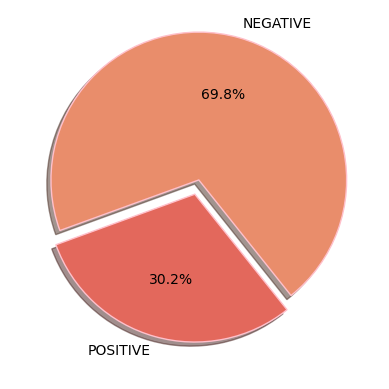

In [70]:
category_counts = df_video['status'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=200, counterclock=False, 
         wedgeprops={'edgecolor': 'pink'}, explode=[0.1, 0], shadow=True, colors=sns.color_palette('flare'))
plt.show()

#### Conclusión
El vídeo cuenta con un 69,8% de comentarios negativos y un 30,2% de comentarios positivos

Mostrar algunos comentarios positivos y algunos negativos al azar

In [71]:
# Eligir comentarios positivos y negativos aleatorios y guardarlos en una lista
indices_positive = df_video[df_video['status'] == 'POSITIVE']
indices_negative = df_video[df_video['status'] == 'NEGATIVE']
# print(indices_positive.head(5))
qty = 100
positive_comments = indices_positive["text_without_emojis"]
# [1:qty]
# .tolist()
negative_comments = indices_negative["text_without_emojis"]
# [1:qty]
# ["original_text"].tolist()
l_pos = np.random.choice(positive_comments.values.tolist(), qty, replace=False)
l_neg = np.random.choice(negative_comments.values.tolist(), qty, replace=False)


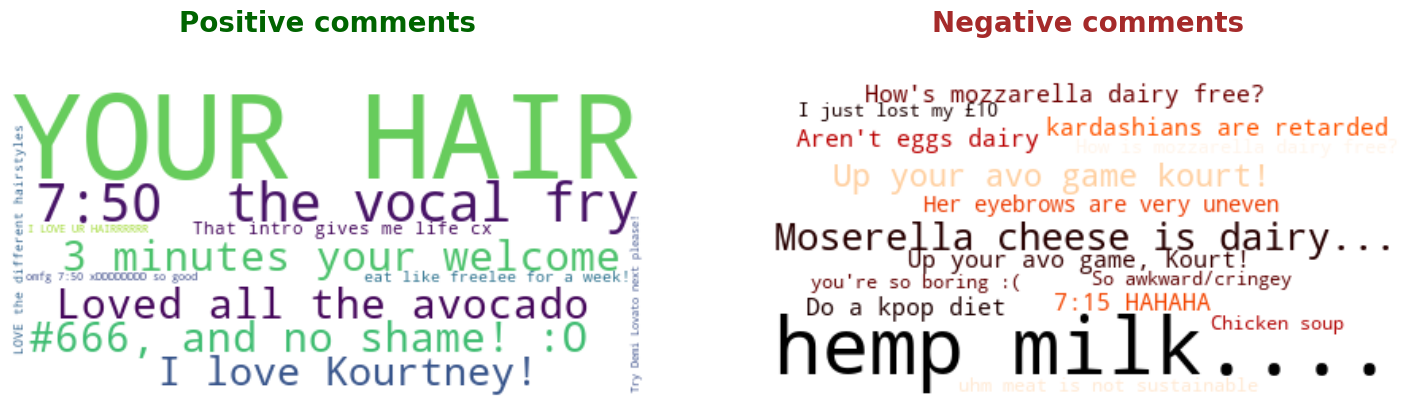

In [72]:
# Mostrar los comentarios positivos y negativos en una nube de palabras
#!pip install wordcloud
from collections import Counter
from wordcloud import WordCloud

fig,ax = plt.subplots(1,2, figsize=(18, 10))
word_cloud_lst_pos = Counter(list(filter(lambda x: len(x) < 30, l_pos )))
wordcloud_pos = WordCloud(max_font_size=250, max_words=30, background_color="white").generate_from_frequencies(word_cloud_lst_pos)

word_cloud_lst_neg = Counter(list(filter(lambda x: len(x) < 30, l_neg )))
wordcloud_neg = WordCloud(max_font_size=250, max_words=30, background_color="white", colormap="gist_heat").generate_from_frequencies(word_cloud_lst_neg)

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title("Positive comments", fontsize=20, y=1.05, color="darkgreen", weight='bold', pad=20, loc='center', verticalalignment='bottom')
ax[0].set_axis_off()   
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title("Negative comments", fontsize=20, y=1.05, color="brown", weight='bold', pad=20, loc='center', verticalalignment='bottom')
ax[1].set_axis_off()
plt.show()

### 3.2. Detectar el contenido del video a traves de palabras más frecuentes

Definiendo funciones para preprocesar los datos con los siguientes objetivos: 
- Exclusión de palabras comunes
- Cálculo de frecuencia de palabras

El preprocesamiento de datos para este paso en particular implica abordar la presencia de palabras generales que ocurren con frecuencia (como "she", "he", "it", "there", "was", etc.) que pueden distorsionar los resultados al detectar el tema del video. Nuestro objetivo es calcular con precisión las palabras más frecuentes relacionadas directamente con el contenido del video, minimizando al mismo tiempo el impacto de palabras comunes y no informativas.

In [38]:
# Exclusión de palabras comunes 
def remove_specific_words(text):
    words_to_remove = [
        "i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
        "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", 
        "himself", "she", "her", "hers", "herself", "it", "its", "itself", 
        "they", "them", "their", "theirs", "themselves", "what", "which", "who", 
        "whom", "this", "that", "these", "those", "am", "is", "are", "was", 
        "were", "be", "been", "being", "have", "has", "had", "having", "do", 
        "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", 
        "because", "as", "until", "while", "of", "at", "by", "for", "with", 
        "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", 
        "on", "off", "over", "under", "again", "further", "then", "once", 
        "here", "there", "when", "where", "why", "how", "all", "any", "both", 
        "each", "few", "more", "most", "other", "some", "such", "no", "nor", 
        "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", 
        "can", "will", "just", "don", "don't", "should", "should've", "now", 
        "d", "ll", "m", "o", "re", "ve", "y", "ain", "aren", "aren't", "couldn", 
        "couldn't", "didn", "didn't", "doesn", "doesn't", "hadn", "hadn't", 
        "hasn", "hasn't", "haven", "haven't", "isn", "isn't", "ma", "mightn", 
        "mightn't", "mustn", "mustn't", "needn", "needn't", "shan", "shan't", 
        "shouldn", "shouldn't", "wasn", "wasn't", "weren", "weren't", "won", 
        "won't", "wouldn", "wouldn't","this", "so", "the", "i", "in", "look", 
        "this", "your", "a", "about", "and", "it", "little", "on", "with", "you", "for", "that", "be", "of", 
        "just", "my", "to", "I'm", "but", "have", "sorry", "is", "as", "me", "would",
        "can", "had", "get", "i", "all", "are", "her", "not", "after", "also", "at", "because",
        "better", "even", "make", "dont", "don’t", "anything", "she", "was", "one", "only", "or",
        "out", "really", "much", "there"]   
    
    symbols = [',', '.', '!', '?', ';', ':', '(', ')', '[', ']', '{', '}', "'", '"', '<', '>', '/', '\\', '|', 
           '`', '~', '#', '$', '%', '^', '&', '*', '-', '_', '+', '=', '–']
    
    words = text.split()
    cleaned_words = [word.lower() for word in words if word.lower() not in words_to_remove]
    for symb in symbols:
        cleaned_words = [word.replace(symb, '') for word in cleaned_words]
    return cleaned_words

# Cálculo de frecuencia de palabras
def word_count(df, column):
    words_frequency = {}
    def frequency(row):
        # Split the text into words
        words = np.array(row)
        unique_words = np.unique(words[:], return_counts=True)
        print(unique_words)
        for word in unique_words:
            if word[0] not in words_frequency.keys():
                words_frequency[word[0]] = words_frequency[word[1]]
            else:
                words_frequency[word[0]] += words_frequency[word[1]]
    frequency(df[[column]].apply(lambda x: frequency(x)))
    return words_frequency

In [74]:
df_video.info()

<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 145702 to 242833
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   video_id             600 non-null    object 
 1   original_text        600 non-null    object 
 2   likes                600 non-null    int64  
 3   replies              600 non-null    int64  
 4   text_without_emojis  600 non-null    object 
 5   emojis               53 non-null     object 
 6   possible_nouns       600 non-null    object 
 7   language             600 non-null    object 
 8   output               600 non-null    object 
 9   status               600 non-null    object 
 10  score                600 non-null    float64
dtypes: float64(1), int64(2), object(8)
memory usage: 56.2+ KB


Aplicar las funciones definidas y almacenar los resultados en un DataFrame

In [75]:
# Eliminar las palabras que aparecen con más frecuencia como:  'she, he, it, it's, me, her,..',etc. y símbolos.
df_video['words'] = df_video['text_without_emojis'].apply(lambda x: " ".join(remove_specific_words(x)))

frecuencia_palabras = df_video['words'].str.lower().str.split(expand=True).stack().value_counts()
df_frecuencias = frecuencia_palabras.reset_index(name="counts")
df_frecuencias = df_frecuencias.rename(columns={"index":"words"})
# df_frecuencias.head(20).plot.bar(x='words', y='counts')

df_frecuencias.head()

,words,counts
0,like,129
1,dairy,124
2,free,99
3,gluten,83
4,diet,70


Visualizar los resultados

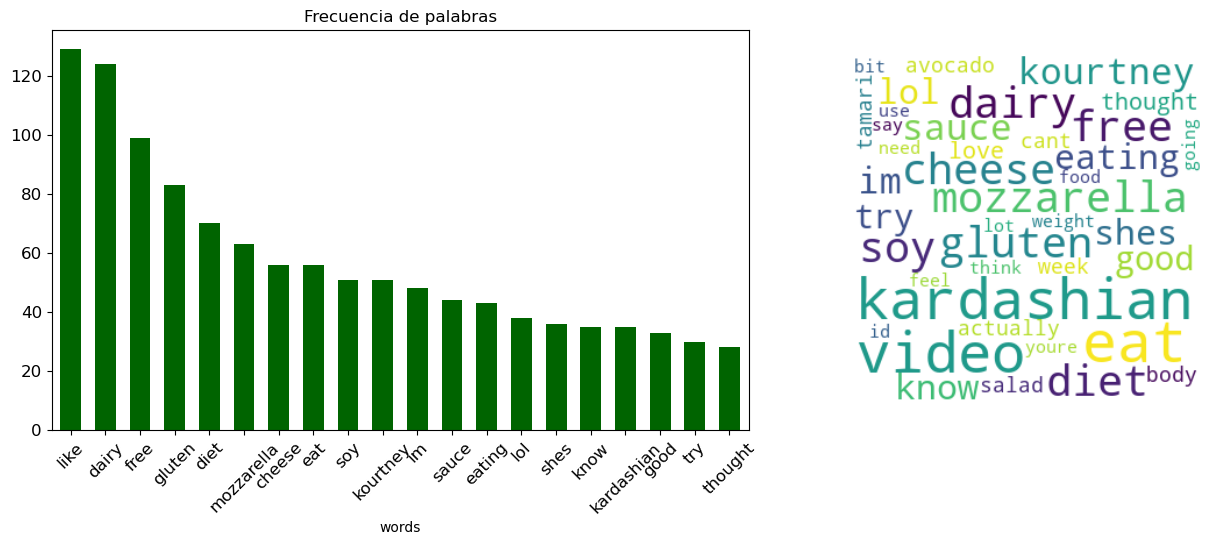

In [76]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
words = df_frecuencias[df_frecuencias['counts'] > 15]
words = words['words'].tolist()
wc = WordCloud(width = 300, height = 300, max_font_size = 50, min_font_size = 10, background_color="white")
wc.generate(" ".join(words))

fig,ax = plt.subplots(1,2, figsize=(30, 10),  gridspec_kw={'width_ratios': [2, 1]})

df_frecuencias.head(20).plot.bar(x='words', y='counts', figsize=(20, 5), color='darkgreen', title="Frecuencia de palabras",width=0.6, rot=45, fontsize=12, legend=None, ax=ax[0])
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")
plt.subplots_adjust(right=0.7, top=0.9, bottom=0.1, wspace=0.2, hspace=0.2)

#### Conclusión

El video parece tratar sobre una forma especial de alimentación, con palabras como "sin lácteos", "gluten" y "dieta" que aparecen con frecuencia. Parece que hablan sobre el uso de diferentes ingredientes como "soja" y "mozzarella". También podrían compartir experiencias personales y recetas. En resumen, es probable que el video se centre en explorar y hablar sobre una forma específica de comer, posiblemente influenciada por una figura pública como Kourtney Kardashian.

### 3.3. Sugerir el motivo por el cual el comentario puede ser positivo o negativo
Estimar qué palabras aparecen predominantemente en comentarios positivos y negativos


In [77]:
df_video["id"] = df_video.index + 1
df_palabras = df_video[["id","words"]]
df_palabras["words"] = df_palabras["words"].apply(lambda x: x.split(" "))
df_cruzado = df_palabras.explode('words', ignore_index=True)
df_cruzado = df_cruzado.drop_duplicates()
df_cruzado2 = df_frecuencias.head(20).merge(df_cruzado, on='words')
## Medir el impacto negativo que puede tener un video a partir de sus comentarios
df_salida = df_video.merge(df_cruzado2, how="inner", on="id")
# df_salida.drop(columns=["original_text"]).head(5)


Visualizar el resultado

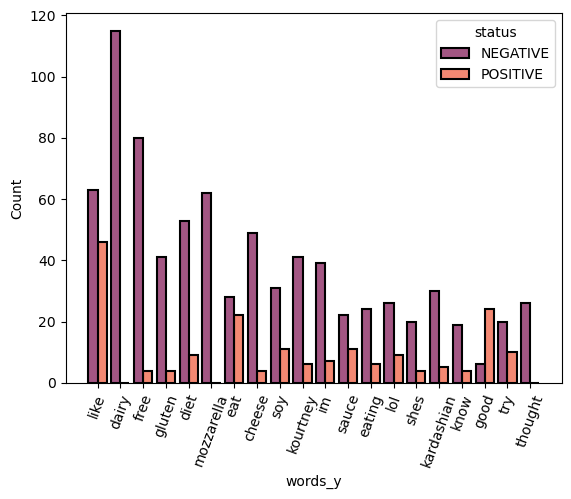

In [78]:
sns.histplot(data=df_salida.sort_values(by="counts", ascending=False), x="words_y", hue="status", multiple="dodge", linewidth=1.5, shrink=0.8, palette="rocket")
plt.xticks(rotation=70)
plt.show()

#### Conclusión
El gráfico indica que la mayoría de las palabras frecuentes aparecen en comentarios negativos, excepto palabras como 'good' y 'like'. Basándonos en esta observación, se puede suponer que la mayoría de los comentarios son negativos y las palabras 'dairy,' 'gluten,' 'mozzarella,' 'cheese,' y 'free' en comentarios negativos sugieren una posible insatisfacción relacionada con las preferencias alimentarias.

Mostrar los comentarios que han obtenido más respuestas

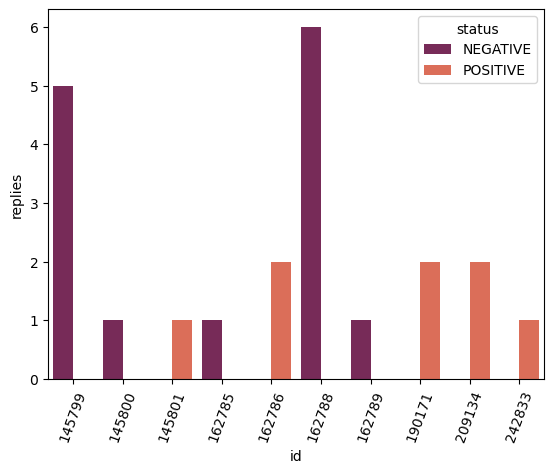

,id,original_text
178,145799,dairy free?....You were eating so many eggs !
180,145800,"If Kourtney says she's vegan, but uses honey and bone broth...girl ain't vegan lol."
183,145801,eat like freelee for a week!
342,162785,"If Kourtney says she's vegan, but uses honey and bone broth...girl ain't vegan lol."
345,162786,eat like freelee for a week!
347,162788,dairy free?....You were eating so many eggs !
349,162789,You say at the beginning that you chose Kourtney because she hasn't been accused of going under the knife but she herself has said she's had breast implants!
500,190171,eat like freelee for a week!
652,209134,eat like freelee for a week!
980,242833,kourtney got a boob job


In [79]:
sns.barplot(data=df_salida[df_salida["replies"]!=0], x="id", y="replies", hue="status", palette="rocket")
plt.xticks(rotation=70)
plt.show()
df_salida[df_salida["replies"]!=0][["id","original_text"]].drop_duplicates().head(20)


#### Conclusión
El gráfico destaca los comentarios que recibieron respuestas, y el que tiene más respuestas es negativo. Dice,  "Dairy-free?...You were eating so many eggs!" Esto sugiere que la persona podría estar confundida o molesta cuando el video no coincide con lo que esperaban. Como sugerencia de mejora, el autor podría considerar hacer el contenido del video más claro, asegurándose de que se alinee mejor con cualquier etiqueta dietética utilizada.

### 4. Repetir el algoritmo en otro video 
### 4.1. Tomar un video aleatorio

In [80]:
# Tomar un video aleatorio
np.random.seed(666)
random_ind = np.random.randint(len(df['video_id']))
random_video_id = df.iloc[random_ind].iloc[0]
random_video_id

'JV1NB70gLQI'

In [81]:
# crear un data frame con un video aleatorio
df_video_selected = df[df['video_id']==random_video_id]
df_video_selected.count()

video_id        400
comment_text    400
likes           400
replies         400
dtype: int64

### 4.2. Preprocesamiento de datos

Eliminar datos nulos si existen

In [82]:
# Comprobar si tenemos datos nulos y si es así los descartamos
nulls = df_video_selected.isnull().sum()
if len(nulls[nulls>0]) > 0:
    indices_null = df_video_selected['comment_text'].isnull().index
    df_video_selected.drop(df_video_selected['comment_text'][df_video_selected['comment_text'].isnull()].index, inplace=True)

Aplicar las funciones definidas antes y almacenar los resultados en un DataFrame con referencias a los comentarios originales y nuevos comentarios.

In [83]:
df_video = df_video_selected
df_video.rename(columns={"comment_text":"original_text"}, inplace=True)
df_video['text_without_emojis'] = df_video['original_text'].apply(lambda x: emoji_pattern.sub(r'', x))
df_video['emojis'] = df_video['original_text'].apply(lambda x: find_emojis(x))
df_video['possible_nouns'] = df_video['text_without_emojis'].apply(lambda x: [search_nouns(i) for i in x.split(" ")])
df_video['possible_nouns'] = df_video['possible_nouns'].apply(lambda x: list(filter(lambda item: item is not None, x)))
df_video['text_without_emojis'] = df_video['text_without_emojis'].apply(lambda x: no_letters(x)) # Aseguramos que todas las cadenas tengan comentarios
df_video['language'] = df_video['text_without_emojis'].apply(lambda x: detect_and_convert_language(x))

Mostramos el resultado de la tabla

In [84]:
df_video.head(5)

,video_id,original_text,likes,replies,text_without_emojis,emojis,possible_nouns,language
320730,JV1NB70gLQI,35 second ad at the beginning? this CATS people are spending the big bucks !!!,22,0,35 second ad at the beginning? this CATS people are spending the big bucks !!!,None,[CATS],English
320731,JV1NB70gLQI,"Rothschild, Rockefeller, Morgan, DuPont. They control banking, energy, education, health, food, military, entertainment, media.",21,0,"Rothschild, Rockefeller, Morgan, DuPont. They control banking, energy, education, health, food, military, entertainment, media.",None,"[Rothschild, Rockefeller, Morgan, DuPont, They]",English
320732,JV1NB70gLQI,"Rothschild Bank, control almost every central banks in the world, control the world financial system, even Bill Gates or Donald Trump cannot stand against them.",6,0,"Rothschild Bank, control almost every central banks in the world, control the world financial system, even Bill Gates or Donald Trump cannot stand against them.",None,"[Rothschild, Bank, Bill, Gates, Donald, Trump]",English
320733,JV1NB70gLQI,And Coca-Cola Company?,7,0,And Coca-Cola Company?,None,"[And, Coca, Company]",English
320734,JV1NB70gLQI,"VW Group doesn't own Porsche per se, but it does own the Porsche brand. However, Porsche SE owns VW Group (due to taxes).",0,0,"VW Group doesn't own Porsche per se, but it does own the Porsche brand. However, Porsche SE owns VW Group (due to taxes).",None,"[VW, Group, Porsche, Porsche, However, Porsche, SE, VW, Group]",English


Los datos fueron preprocesados ​​para un paso posterior.

### 4.3. Detectar comentarios positivos y negativos

Cargar el modelo de análisis de sentimiento y aplicarlo en el conjunto de datos

In [85]:
sentiment_pipeline = pipeline(task="sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
All PyTorch model weights were used when initializing TFDistilBertForSequenceClassification.

All the weights of TFDistilBertForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [86]:
# Aplicar el modelo en el conjunto de datos
df_video['output'] = df_video['text_without_emojis'].apply(lambda x: sentiment_pipeline(x))

In [87]:
df_video['status'] = df_video['output'].apply(lambda x: x[0]['label'])
df_video['score'] = df_video['output'].apply(lambda x: x[0]['score'])
# df_video.drop(columns=["output"], inplace=True)
# df_video.head(10)

Visualizar los resultados

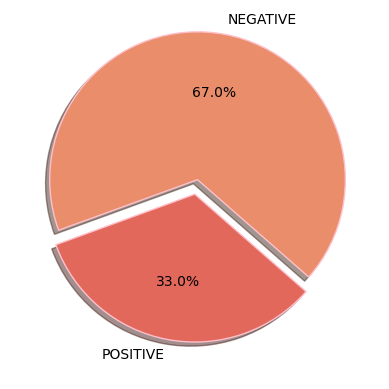

In [88]:
category_counts = df_video['status'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=200, counterclock=False, 
         wedgeprops={'edgecolor': 'pink'}, explode=[0.1, 0], shadow=True, colors=sns.color_palette('flare'))
plt.show()

#### Conclusión
El vídeo cuenta con un 67,0% de comentarios negativos y un 33,0% de comentarios positivos



Mostrar algunos comentarios positivos y algunos negativos al azar

In [89]:
# Eligir comentarios positivos y negativos aleatorios y guardarlos en una lista
indices_positive = df_video[df_video['status'] == 'POSITIVE']
indices_negative = df_video[df_video['status'] == 'NEGATIVE']
# print(indices_positive.head(5))
qty = 100
positive_comments = indices_positive["text_without_emojis"]
# [1:qty]
# .tolist()
negative_comments = indices_negative["text_without_emojis"]
# [1:qty]
# ["original_text"].tolist()
l_pos = np.random.choice(positive_comments.values.tolist(), qty, replace=False)
l_neg = np.random.choice(negative_comments.values.tolist(), qty, replace=False)

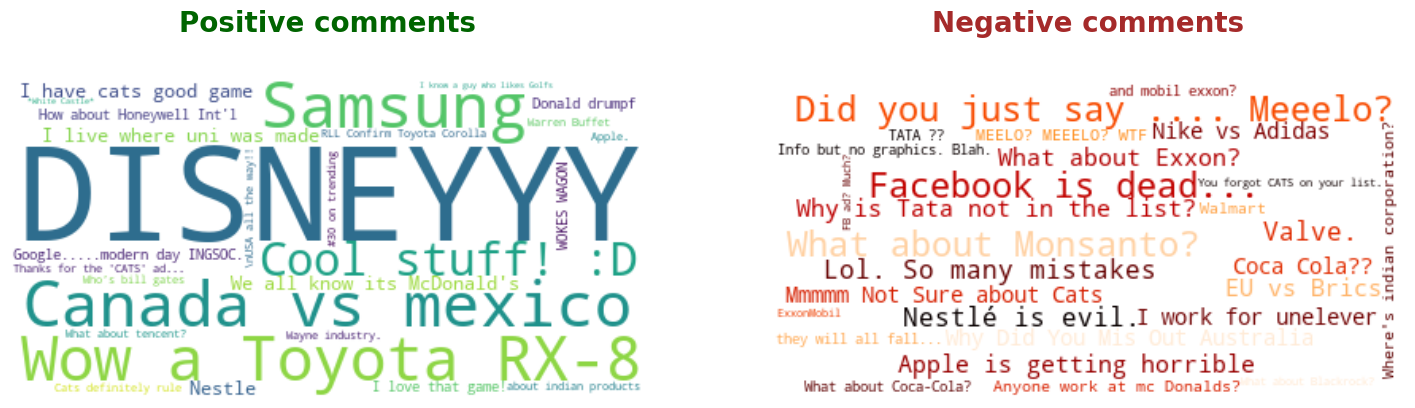

In [90]:
# Mostrar los comentarios positivos y negativos en una nube de palabras
#!pip install wordcloud
from collections import Counter
from wordcloud import WordCloud

fig,ax = plt.subplots(1,2, figsize=(18, 10))
word_cloud_lst_pos = Counter(list(filter(lambda x: len(x) < 30, l_pos )))
wordcloud_pos = WordCloud(max_font_size=250, max_words=30, background_color="white").generate_from_frequencies(word_cloud_lst_pos)

word_cloud_lst_neg = Counter(list(filter(lambda x: len(x) < 30, l_neg )))
wordcloud_neg = WordCloud(max_font_size=250, max_words=30, background_color="white", colormap="gist_heat").generate_from_frequencies(word_cloud_lst_neg)

ax[0].imshow(wordcloud_pos, interpolation='bilinear')
ax[0].set_title("Positive comments", fontsize=20, y=1.05, color="darkgreen", weight='bold', pad=20, loc='center', verticalalignment='bottom')
ax[0].set_axis_off()   
ax[1].imshow(wordcloud_neg, interpolation='bilinear')
ax[1].set_title("Negative comments", fontsize=20, y=1.05, color="brown", weight='bold', pad=20, loc='center', verticalalignment='bottom')
ax[1].set_axis_off()
plt.show()

### 4.4. Detectar el contenido del video a traves de palabras más frecuentes

Aplicar las funciones definidas y almacenar los resultados en un DataFrame

In [92]:
# Eliminar las palabras que aparecen con más frecuencia como:  'she, he, it, it's, me, her,..',etc. y símbolos.
df_video['words'] = df_video['text_without_emojis'].apply(lambda x: " ".join(remove_specific_words(x)))

frecuencia_palabras = df_video['words'].str.lower().str.split(expand=True).stack().value_counts()
df_frecuencias = frecuencia_palabras.reset_index(name="counts")
df_frecuencias = df_frecuencias.rename(columns={"index":"words"})
# df_frecuencias.head(20).plot.bar(x='words', y='counts')

Visualizar el resultado

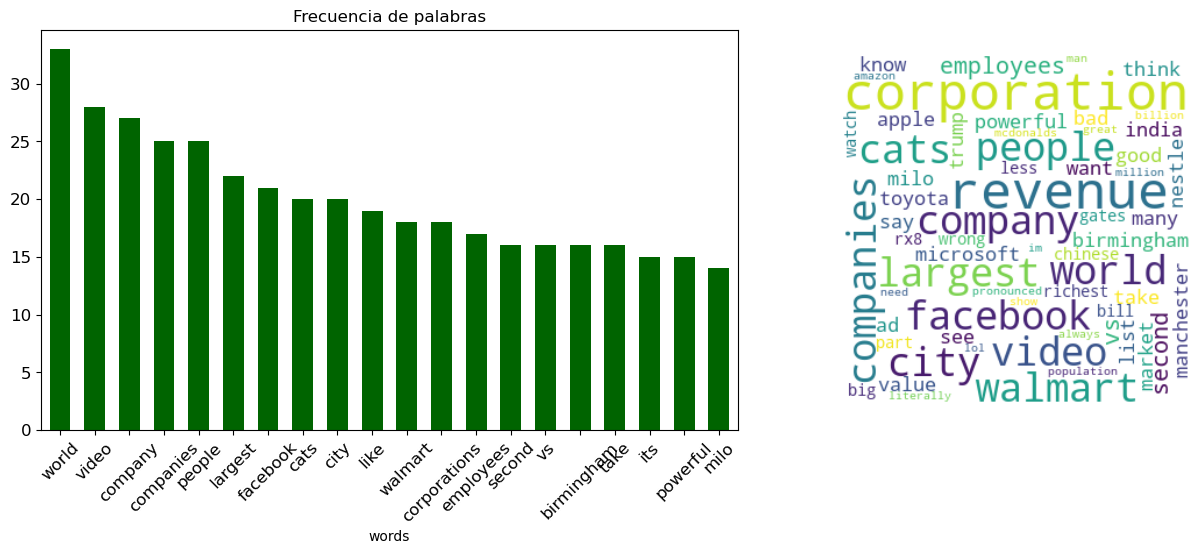

In [93]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
words = df_frecuencias[df_frecuencias['counts'] > 5]
words = words['words'].tolist()
wc = WordCloud(width = 300, height = 300, max_font_size = 50, min_font_size = 10, background_color="white")
wc.generate(" ".join(words))

fig,ax = plt.subplots(1,2, figsize=(30, 10),  gridspec_kw={'width_ratios': [2, 1]})

df_frecuencias.head(20).plot.bar(x='words', y='counts', figsize=(20, 5), color='darkgreen', title="Frecuencia de palabras",width=0.6, rot=45, fontsize=12, legend=None, ax=ax[0])
ax[1].imshow(wc, interpolation="bilinear")
ax[1].axis("off")
plt.subplots_adjust(right=0.7, top=0.9, bottom=0.1, wspace=0.2, hspace=0.2)

#### Conclusión

El análisis de frecuencia de palabras revela varios temas destacados en el contenido. "World" es la palabra más frecuente, seguida de "video" y "company", lo que sugiere que el contenido podría abordar temas globales, multimedia y empresariales. La presencia de palabras como "largest", "facebook", y "corporations" indica un posible enfoque en empresas y corporaciones a nivel mundial.

La inclusión de "cats" y "city" sugiere que el contenido podría tener elementos relacionados con animales y entornos urbanos. Además, la presencia de "employees" y "walmart", "Facebook" indica la posible discusión sobre empleados y las empresas Walmart y Facebook en particular.

En resumen, el contenido parece ser diverso, abarcando temas que van desde lo global y empresarial hasta aspectos más específicos como animales y entornos urbanos. Es probable que la información se centre en la intersección de diversos temas, proporcionando una visión amplia y variada.

### 4.5. Sugerir el motivo por el cual el comentario puede ser positivo o negativo
Estimar qué palabras aparecen predominantemente en comentarios positivos y negativos

In [94]:
df_video["id"] = df_video.index + 1
df_palabras = df_video[["id","words"]]
df_palabras["words"] = df_palabras["words"].apply(lambda x: x.split(" "))
df_cruzado = df_palabras.explode('words', ignore_index=True)
df_cruzado = df_cruzado.drop_duplicates()
df_cruzado2 = df_frecuencias.head(20).merge(df_cruzado, on='words')
## Medir el impacto negativo que puede tener un video a partir de sus comentarios
df_salida = df_video.merge(df_cruzado2, how="inner", on="id")
# df_salida.drop(columns=["original_text"]).head(5)


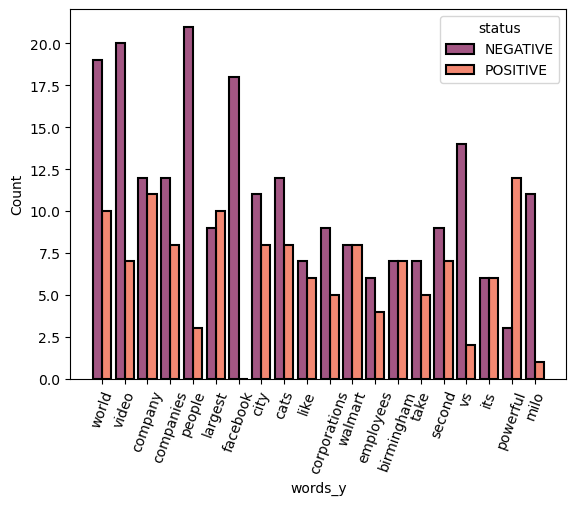

In [95]:
sns.histplot(data=df_salida.sort_values(by="counts", ascending=False), x="words_y", hue="status", multiple="dodge", linewidth=1.5, shrink=0.8, palette="rocket")
plt.xticks(rotation=70)
plt.show()

#### Conclusión
El gráfico indica que la mayoría de las palabras frecuentes en comentarios negativos incluyen términos como 'world', 'video', 'companies' y 'Facebook'. Aunque se observan palabras neutrales como 'powerful' y 'city', la tendencia general parece ser negativa.

Es probable que la negatividad provenga de preocupaciones globales, descontento con el contenido de video, críticas a empresas y problemas relacionados con las redes sociales. Aunque hay cierta diversidad de opiniones, la presencia de términos negativos sugiere que hay áreas de insatisfacción significativas, especialmente en temas globales y en el ámbito de las redes sociales y las empresas.

Mostrar los comentarios que han obtenido más respuestas

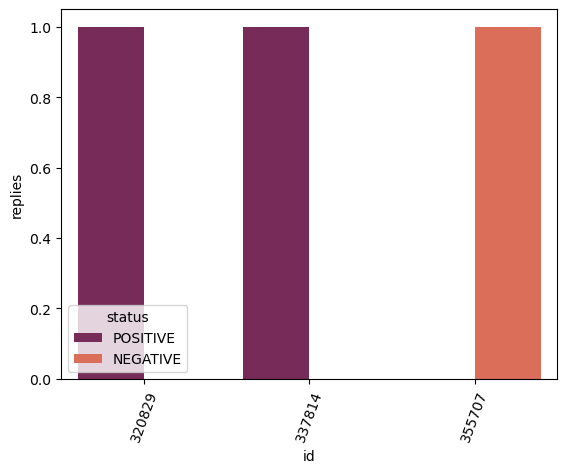

,id,original_text
100,320829,Most powerful company : *Microsoft*\nBecause most of the company uses Microsoft *Office product* for their business.
183,337814,Wtf do statistics have to do with power? Power is not a 1 dimensional thing. Nestle is probably one of the most powerful because billions of people literally depend on them for food
273,355707,"Corporations are inherently evil because they exist in a realm where now its no longer best to compete, which DOES bring out the best of humanity. Corporations work together now to screw the little guy. And they've purchased the politcal class on both sides the western world over. This is why our representatives don't represent us they represent their corporate donors which allowed them to win the race for the 17th time running... While watching this I was proud to look around my room and not see ONE GODDAMN IOTA OF CORPORATE PRODUCT! If things like adblock didn't exist i wouldn't even be using this website. I have a youtube channel too, But i don't expect filming myself to pay the bills..."


In [96]:
sns.barplot(data=df_salida[df_salida["replies"]!=0], x="id", y="replies", hue="status", palette="rocket")
plt.xticks(rotation=70)
plt.show()
df_salida[df_salida["replies"]!=0][["id","original_text"]].drop_duplicates().head(20)

#### Conclusión
El gráfico destaca los comentarios que recibieron respuestas. Con la tabla proporcionada de esos comentarios, podemos ver que la gente está involucrada en la discusión sobre las empresas. Entre los comentarios que generaron respuestas, el más interactuado es negativo, expresando preocupaciones sobre la cooperación de las corporaciones y su influencia política. Los comentarios positivos destacan la influencia de Microsoft en el mundo empresarial.

### Conclusiones:

En este proyecto, se realizó un análisis de los comentarios de un video de YouTube, abordando múltiples aspectos desde la recopilación de datos hasta la detección de sentimientos y palabras clave. A continuación, se resumen las acciones realizadas:

1. **Recopilación y Tratamiento de Datos:**
   - Los datos fueron recopilados y tratados con herramientas específicas, eliminando nulos, limpiando emojis y aplicando funciones para detectar nombres propios, manejar comentarios numéricos o con enlaces, y determinar el idioma predominante.

2. **Diseño del Modelo de Datos:**
   - Se diseñó un modelo que incluye la detección de comentarios positivos y negativos mediante un modelo de análisis de sentimientos. Además, se exploró el contenido del video mediante el cálculo de palabras más frecuentes, excluyendo términos comunes.

3. **Sugerencias de Mejora y Análisis Adicional:**
   - Se sugirió que la negatividad en los comentarios podría estar relacionada con expectativas no cumplidas respecto a las preferencias alimentarias. Además, se exploraron palabras clave que podrían indicar motivos para comentarios positivos y negativos.
   

4. **Repetición del Algoritmo en Otro Video Aleatorio:**
   - Se llevó a cabo la repetición completa del algoritmo en otro video aleatorio como demostración de que este proyecto puede servir como una plantilla inicial para realizar el análisis de los comentarios de los usuarios.

### Aplicaciones Potenciales:

Este proyecto puede tener aplicaciones significativas en diversas áreas, como:

- **Optimización de Contenido en Plataformas de Video:**
  - Mejorar la calidad del contenido y la interacción con la audiencia al comprender las expectativas y preferencias de los espectadores.

  - **Análisis de Reseñas de Tiendas en Línea:**
  - Aplicar el modelo de análisis de sentimientos para evaluar reseñas de productos en tiendas en línea y comprender la satisfacción del cliente.

- **Automatización de Moderación de Comentarios:**
  - Implementar el análisis de sentimientos para moderar automáticamente comentarios, identificando y filtrando contenido ofensivo.

